# Project Name: Detecting Ships using Satellite Images with Deep Learning
Contributor: Rajeev Singh Sisodiya


Project details: Workflow of this notebook
(1) Introducing Dataset

(2) Quick guide on Object Detection, Image Classification and Segmentation

(3) Importing necessary libraries and modules for this notebook

(4) Exploring the Dataset

(5) Grasping the idea of Run Length Encoding and Decoding

(6) Preparing data for our model

(7) Brief introduction to UNET model

(8) Build and train UNET model

## Dataset & Aim<a class="anchor"  id="h1"></a>
    
<img src = "https://eoimages.gsfc.nasa.gov/images/imagerecords/2000/2938/SinkingShip_10_15_02_lrg.jpg" width = 35%>  
       
- We will be dealing with [this dataset](https://www.kaggle.com/competitions/airbus-ship-detection).
- Search "Airbus Ship Detection Dataset".
- It consists of train and test image folders along with sample_submission and train_ship_segmentation csv files.
- Soon we will jump into more details of these files.
- We will build and train UNET model from scratch for image segmentaion.

## Image Classification, Object Detection and Semantic Segmentation <a class="anchor"  id="h2"></a>

- If you are new to computer vision then these terms may confuse you.
- These are some of the most common applications of machine learning in computer vision.
- Below is a quick guide before we start exploring our data.

<img src = "https://i1.wp.com/bdtechtalks.com/wp-content/uploads/2021/05/image-classification-vs-object-detection-vs-semantic-segmentation.jpg" width = 65%>

* **Image Classificaton:-** Determines whether a certain type of object is present in an image or not.    
* **Object Detection:-** Object detection takes image classification one step further and provides the bounding box where detected objects are located.        
* **Semantic Segmentation:-** Specifies the object class of each pixel in an input image. This is what we are targeting in this notebook!  
* **Instance Segmentation:-** Separates individual instances of each type of object.

The images below and above shall help you visualize these ideas.

<img src = "https://deeplobe.ai/wp-content/uploads/2021/05/SENTIMENT-ANALYSIS-1024x683.png" width = 65%>

*You can read more about it over <u>[here](https://venturebeat.com/ai/new-deep-learning-model-brings-image-segmentation-to-edge-devices/)</u>.*

## Importing libraries and modules needed for this notebook <a class="anchor"  id="h2.5"></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import label

import gc
gc.enable()

**Documents of the above used libraries and modules in case you aren't familiar and want to know more about it:-**
- [os](https://docs.python.org/3/library/os.html)
- [numpy](https://numpy.org/doc/1.23/user/absolute_beginners.html)
- [pandas](https://pandas.pydata.org/docs/user_guide/index.html#user-guide)
- [seaborn](https://seaborn.pydata.org/tutorial/introduction.html)
- [matplotlib.pyplot](https://matplotlib.org/stable/tutorials/introductory/pyplot.html)
- [skimage.io.imread](https://scikit-image.org/docs/stable/api/skimage.io.html#skimage.io.imread)
- [skimage.segmentation.mark_boundaries](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.mark_boundaries)
- [skimage.util.montage](https://scikit-image.org/docs/stable/api/skimage.util.html#skimage.util.montage)
- [skimage.morphology.label](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.label)
- [gc.enable()](https://docs.python.org/3/library/gc.html)


EDA
## Exploring the data <a class="anchor"  id="h3"></a>

In [ ]:
train_image_dir = '/kaggle/input/airbus-ship-detection/train_v2'

In [ ]:
train_images = os.listdir(train_image_dir)

In [ ]:
train_images.sort()

In [ ]:
print(f"Total of {len(train_images)}images in train directory.\nHere is how first 5 train_images looks like:- {train_images[:5]}")

Total of 192556images in train directory.
Here is how first 5 train_images looks like:- ['00003e153.jpg', '0001124c7.jpg', '000155de5.jpg', '000194a2d.jpg', '0001b1832.jpg']


In [ ]:
image_ids = [file for file in os.listdir(train_image_dir) if file.endswith('.jpg')]

In [ ]:
len(image_ids)

192556

In [ ]:
image_ids[0]

'd8bc90fd6.jpg'

In [ ]:
masks = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')

In [ ]:
masks.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [ ]:
# Filter the DataFrame
filtered_df = masks[masks['ImageId'].isin(image_ids)]

In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


In [ ]:
filtered_df

ImageId                                      EncodedPixels
0       00003e153.jpg                                                NaN
1       0001124c7.jpg                                                NaN
2       000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3       000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4       000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...               ...                                                ...
231718  fffedbb6b.jpg                                                NaN
231719  ffff2aa57.jpg                                                NaN
231720  ffff6e525.jpg                                                NaN
231721  ffffc50b4.jpg                                                NaN
231722  ffffe97f3.jpg                                                NaN

[231723 rows x 2 columns]

- Here, we can see some image ids are repeated. That is because we are given masks for each ship in one image.
- This simply means that number of ships in train image = total of repeated image ids in this masks data frame.
- NaN simply means that there are no ships in that image.
- **We can combine this masks into one image for same image ids.**
- Before that we need to make ourselves comfortable with this encoded format.

## Run Length Encoding (RLE) and Decoding <a class="anchor"  id="h4"></a>
- Run length encoding is a lossless compression.
- Lossless compression allows the original data to be perfectly reconstructed from the compressed data.
- We simply run through the data and count how many times each data point is repeated without any breaks.
- Consider a small example below to grasp this idea:-

<img src = "https://img.api.video/1628663040-run-length.png?auto=format&dpr=1&fm=jpg&w=1370" width = 35%>

- We tend to use RLE for data that contains long runs of the same value.
- If your data is complex without long runs then RLE can result in negative compression.
- There are many variations to it - run accross rows, run accross columns, run until pixel changes, etc.
- We also need to decompress the RLE data using run length decoding in order to use it.

**Image example to understand it in a better way:-**    
- Let black pixels be 1 and white pixels be 0 in 10x10 image shown below.     

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcScKG8WJQhjdfUJU2-BBnj7UAgaoF3tK4CZYLRvSjcqjA6H-2BwIwFa3AXRb_Bt2WR5qi4&usqp=CAU" width = 35%>         

In [ ]:
row_rle = ['10 1',
           '4 1 2 0 4 1',
           '3 1 4 0 3 1',
           '2 1 6 0 2 1',
           '1 1 2 0 1 1 2 0 1 1 2 0 1 1',
           '1 1 8 0 1 1',
           '3 1 1 0 2 1 1 0 3 1',
           '2 1 1 0 1 1 2 0 1 1 1 0 2 1',
           '1 1 1 0 1 1 1 0 2 1 1 0 1 1 1 0 1 1',
           '10 1',
           'Total']


In [ ]:
pixels = [len(row.split(" ")) for row in row_rle if row != 'Total']
sum_pixels = np.array(pixels).sum()
pixels.append(sum_pixels)

data = {
    'Row - RLE' : row_rle,
    'Pixels' : pixels
}

rle_df = pd.DataFrame(data)
rle_df.index+=1
rle_df

Row - RLE  Pixels
1                                  10 1       2
2                           4 1 2 0 4 1       6
3                           3 1 4 0 3 1       6
4                           2 1 6 0 2 1       6
5           1 1 2 0 1 1 2 0 1 1 2 0 1 1      14
6                           1 1 8 0 1 1       6
7                   3 1 1 0 2 1 1 0 3 1      10
8           2 1 1 0 1 1 2 0 1 1 1 0 2 1      14
9   1 1 1 0 1 1 1 0 2 1 1 0 1 1 1 0 1 1      18
10                                 10 1       2
11                                Total      84

Clearly we have compressed 100 data points into 84 data points.
Some rows like 5, 8 and 14 gave more data points after encoding than it was in original.
Reason being short runs as there were multiple breaks between black and white pixels.
We can now apply this idea onto our data!

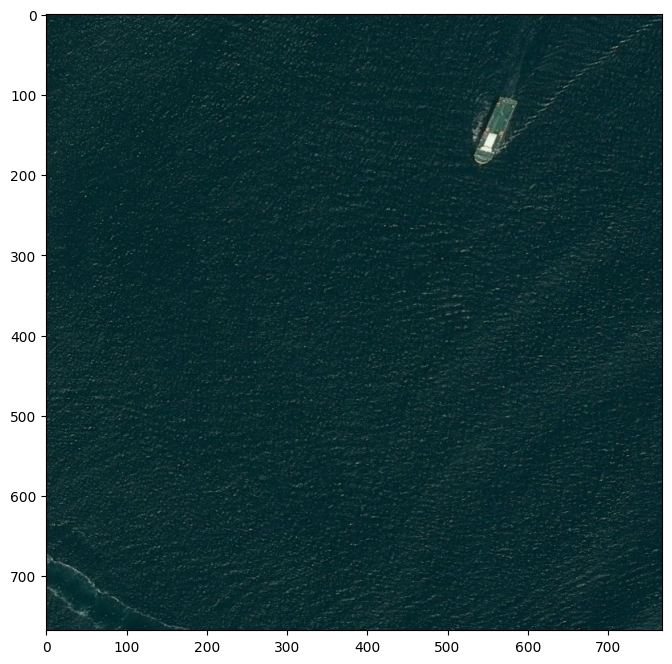

In [ ]:
# Let us now see how it works for Image id:- 0005d01c8.jpg we have in the mask data frame

# Original image from training set
img_arr = imread(train_image_dir + '/' + '0b0f83f31.jpg')
plt.figure(figsize=(15,8))
plt.imshow(img_arr)
plt.show()

In [ ]:
img_arr.shape

(768, 768, 3)

In [ ]:
# Filter out all 0005d01c8.jpg image ids and respective encoded data
# 2 ships means 2 same image ids will be there!
rle_0 = masks.query('ImageId=="0b0f83f31.jpg"')['EncodedPixels']
rle_0

10145    407224 2 407990 4 408756 7 409522 9 410287 13 ...
Name: EncodedPixels, dtype: object

In [ ]:
# Make a list of each mask shown above also visualise whats happening!
mask_lst, ct = [], 1
for mask in rle_0:
    print(f"Mask {ct} -\n{mask}\n\n")
    mask_lst.append(mask)
    ct+=1

Mask 1 -
407224 2 407990 4 408756 7 409522 9 410287 13 411053 15 411819 18 412585 20 413350 24 414116 26 414882 28 415648 31 416413 34 417179 37 417945 39 418711 42 419476 45 420242 48 421008 50 421774 52 422539 56 423305 58 424071 61 424837 63 425602 67 426368 69 427134 72 427900 74 428665 75 429431 75 430197 75 430963 74 431728 75 432494 75 433260 74 434026 74 434791 75 435557 75 436323 74 437089 74 437855 74 438623 71 439392 68 440160 66 440929 62 441697 60 442466 57 443234 54 444003 51 444771 49 445540 46 446308 43 447077 40 447845 38 448613 35 449382 32 450150 30 450919 26 451687 24 452456 21 453224 18 453993 15 454761 13 455530 10 456298 7 457067 4 457835 2




In [ ]:
# Split and Display how the first mask in the list looks like
split = mask_lst[0].split()
print(split)

['407224', '2', '407990', '4', '408756', '7', '409522', '9', '410287', '13', '411053', '15', '411819', '18', '412585', '20', '413350', '24', '414116', '26', '414882', '28', '415648', '31', '416413', '34', '417179', '37', '417945', '39', '418711', '42', '419476', '45', '420242', '48', '421008', '50', '421774', '52', '422539', '56', '423305', '58', '424071', '61', '424837', '63', '425602', '67', '426368', '69', '427134', '72', '427900', '74', '428665', '75', '429431', '75', '430197', '75', '430963', '74', '431728', '75', '432494', '75', '433260', '74', '434026', '74', '434791', '75', '435557', '75', '436323', '74', '437089', '74', '437855', '74', '438623', '71', '439392', '68', '440160', '66', '440929', '62', '441697', '60', '442466', '57', '443234', '54', '444003', '51', '444771', '49', '445540', '46', '446308', '43', '447077', '40', '447845', '38', '448613', '35', '449382', '32', '450150', '30', '450919', '26', '451687', '24', '452456', '21', '453224', '18', '453993', '15', '454761', '

- This data shows start_pixels and lenghts where we can think ship to exist in the original image.
- For example, 56777 3 shows that pixels 56777, 56778, 56779 contributes to the ship.
- Our target is to create an image with these pixels labeled as 1 and remaining as 0.
- This is how we can produce a mask for respective image.

In [ ]:
# Grab all the starting pixels and lenghts and convert it into integers using numpy
starts, lengths = [np.array(x, dtype = int) for x in (split[::2], split[1::2])]
starts, lengths

(array([407224, 407990, 408756, 409522, 410287, 411053, 411819, 412585,
        413350, 414116, 414882, 415648, 416413, 417179, 417945, 418711,
        419476, 420242, 421008, 421774, 422539, 423305, 424071, 424837,
        425602, 426368, 427134, 427900, 428665, 429431, 430197, 430963,
        431728, 432494, 433260, 434026, 434791, 435557, 436323, 437089,
        437855, 438623, 439392, 440160, 440929, 441697, 442466, 443234,
        444003, 444771, 445540, 446308, 447077, 447845, 448613, 449382,
        450150, 450919, 451687, 452456, 453224, 453993, 454761, 455530,
        456298, 457067, 457835]),
 array([ 2,  4,  7,  9, 13, 15, 18, 20, 24, 26, 28, 31, 34, 37, 39, 42, 45,
        48, 50, 52, 56, 58, 61, 63, 67, 69, 72, 74, 75, 75, 75, 74, 75, 75,
        74, 74, 75, 75, 74, 74, 74, 71, 68, 66, 62, 60, 57, 54, 51, 49, 46,
        43, 40, 38, 35, 32, 30, 26, 24, 21, 18, 15, 13, 10,  7,  4,  2]))

In [ ]:
# Get the ending pixels.
'''Examples:-
56010 1 ---> Starts at 56010 and ends at 56010
56777 3 ---> Starts at 56777 and ends at 56779
57544 6 ---> Starts at 57544 and ends at 57549'''
ends = starts + lengths - 1
pd.DataFrame({
    'Starts' : starts,
    'Lengths' : lengths,
    'Ends' : ends
}).head(10)

Starts  Lengths    Ends
0  407224        2  407225
1  407990        4  407993
2  408756        7  408762
3  409522        9  409530
4  410287       13  410299
5  411053       15  411067
6  411819       18  411836
7  412585       20  412604
8  413350       24  413373
9  414116       26  414141

In [ ]:
# Create 1s in place of these pixels and rest should be 0
img = np.zeros(768*768, dtype = np.uint8)
for start, end in zip(starts, ends):
    img[start:end+1] = 1

In [ ]:
# Check how output looks
img[408756:408762] # Should output 0, 1 , 1, 1 ,0 as we know 56777, 56778, 56779 ---> 1 and 5676, 56780 ---> 0

array([1, 1, 1, 1, 1, 1], dtype=uint8)

In [ ]:
# Copy-Paste this idea for another ship in the image
split_1 = mask_lst[0].split()                                                                # Split the mask into start_pixels and lengths
starts, lengths = [np.array(x, dtype = int) for x in (split_1[0:][::2], split_1[1:][::2])]   # Generate arrays from only starts and lengths
ends = starts + lengths - 1                                                                  # Start pixel to end pixel will be start - 1 + length
img1 = np.zeros(768*768, dtype = np.uint8)                                                   # 1D array containing all zeros
for start, end in zip(starts, ends):                                                         # For each start to end pair
    img1[start:end+1] = 1                                                                    # Convert the values from 0 to 1

In [ ]:
# Reshaping both the ship masks and combining it to form the final mask!
img = img.reshape(768, 768)
img1 = img1.reshape(768, 768)
final = img+img1
print(final, '\n\n', final.shape, '\n\n', final.ndim)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

 (768, 768) 

 2


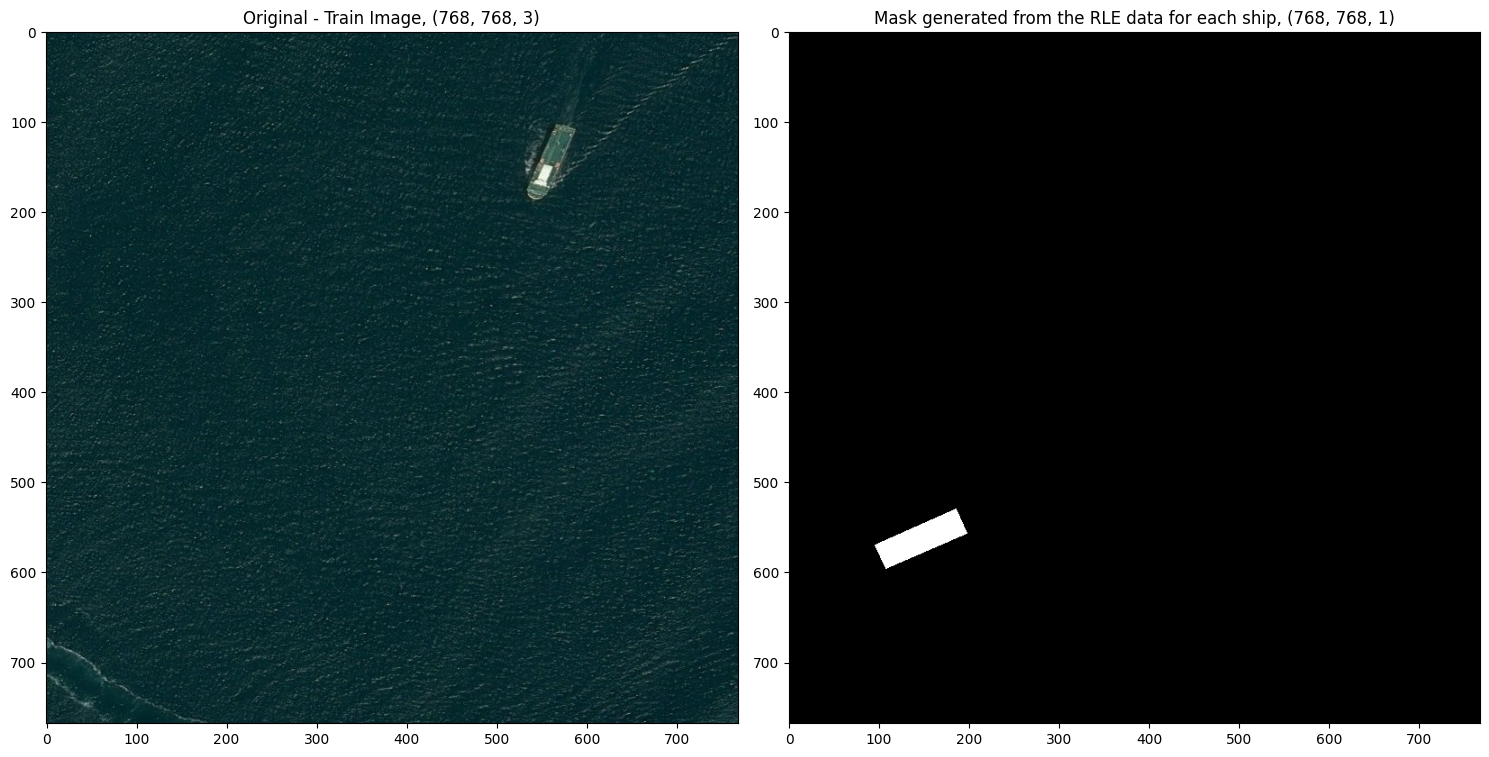

In [ ]:
# Expand dimension of this array to have only 1 channel in the mask and visualise original and final mask
final = np.expand_dims(final, -1) # -1 means the last available dimenstion, in this case it is 2. Hence, on axis = 2 we will get 1.
original = imread(train_image_dir + '/' + '0b0f83f31.jpg')
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.title(f"Original - Train Image, {original.shape}")
plt.imshow(original)
plt.subplot(1, 2, 2)
plt.title(f"Mask generated from the RLE data for each ship, {final.shape}")
plt.imshow(final, cmap = "gray")
plt.tight_layout()
plt.show()

- Oh, something is off!
- Our mask needs to be transposed.

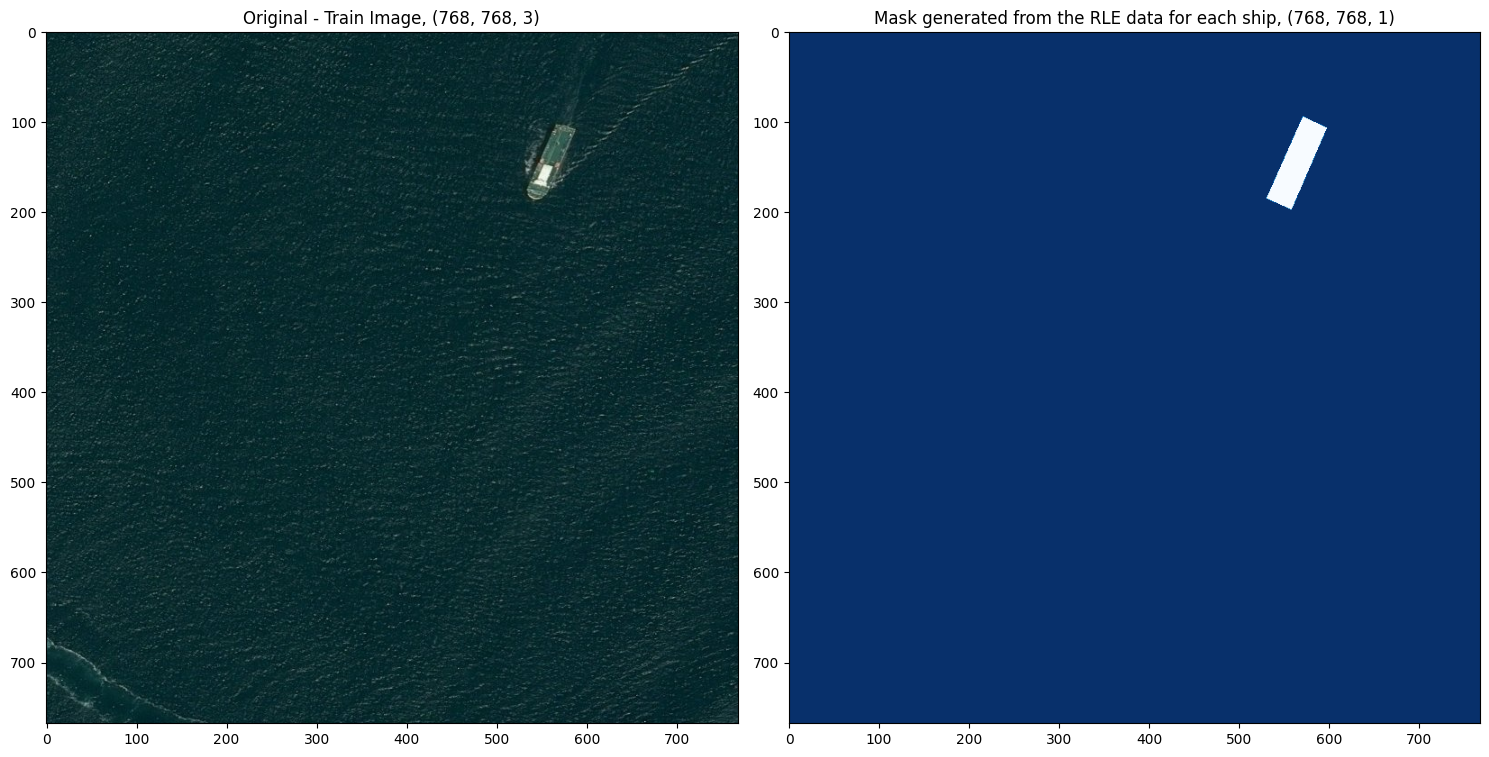

In [ ]:
# Copy Paste the code from the prev cell with one change - Transpose!
img = img.reshape(768, 768).T     # Transpose the first ship mask
img1 = img1.reshape(768, 768).T   # Transpose the second ship mask
final = img+img1                  # Generate the final mask with two ships
final = np.expand_dims(final, -1)
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.title(f"Original - Train Image, {original.shape}")
plt.imshow(original)
plt.subplot(1, 2, 2)
plt.title(f"Mask generated from the RLE data for each ship, {final.shape}")
plt.imshow(final, cmap = "Blues_r")
plt.tight_layout()
plt.show()

- So this is how the EncodedPixels data for one image id looks like!
- We can build a function that can quickly generate such masks for all the EncodedPixels wrt to its ImageId.

In [ ]:
# Define functions to do these tasks for all the training images
def rle_decode(mask_rle, shape=(768,768)):
    '''
    Input arguments -
    mask_rle: Mask of one ship in the train image
    shape: Output shape of the image array
    '''
    s = mask_rle.split()                                                               # Split the mask of each ship that is in RLE format
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]     # Get the start pixels and lengths for which image has ship
    ends = starts + lengths - 1                                                        # Get the end pixels where we need to stop
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)                                  # A 1D vec full of zeros of size = 768*768
    for lo, hi in zip(starts, ends):                                                   # For each start to end pixels where ship exists
        img[lo:hi+1] = 1                                                               # Fill those values with 1 in the main 1D vector
    '''
    Returns -
    Transposed array of the mask: Contains 1s and 0s. 1 for ship and 0 for background
    '''
    return img.reshape(shape).T

def masks_as_image(in_mask_list):
    '''
    Input -
    in_mask_list: List of the masks of each ship in one whole training image
    '''
    all_masks = np.zeros((768, 768), dtype = np.int16)                                 # Creating 0s for the background
    for mask in in_mask_list:                                                          # For each ship rle data in the list of mask rle
        if isinstance(mask, str):                                                      # If the datatype is string
            all_masks += rle_decode(mask)                                              # Use rle_decode to create one mask for whole image
    '''
    Returns -
    Full mask of the training image whose RLE data has been passed as an input
    '''
    return np.expand_dims(all_masks, -1)

Preparing Train and Validation Data

In [ ]:
masks = filtered_df

In [ ]:
'''Note that NaN values in the EncodedPixels are of float type and everything else is a string type'''

# Add a new feature to the masks data frame named as ship. If Encoded pixel in any row is a string, there is a ship else there isn't.
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
masks.head(9)

ImageId                                      EncodedPixels  ships
0  00003e153.jpg                                                NaN      0
1  0001124c7.jpg                                                NaN      0
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...      1
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...      1
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...      1
5  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...      1
6  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...      1
7  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...      1
8  0001b1832.jpg                                                NaN      0

In [ ]:
# Making a new data frame with unique image ids where we are summing up the ship counts
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids.index+=1 # Incrimenting all the index by 1
unique_img_ids.head(25)

ImageId  ships
1   00003e153.jpg      0
2   0001124c7.jpg      0
3   000155de5.jpg      1
4   000194a2d.jpg      5
5   0001b1832.jpg      0
6   00021ddc3.jpg      9
7   0002756f7.jpg      2
8   0002d0f32.jpg      0
9   000303d4d.jpg      0
10  00031f145.jpg      1
11  00052ed46.jpg      0
12  000532683.jpg      2
13  00053c6ba.jpg      1
14  00057a50d.jpg      0
15  000592296.jpg      0
16  0005d01c8.jpg      2
17  0005d6d95.jpg      1
18  0006c52e8.jpg      1
19  0007b8229.jpg      0
20  000805313.jpg      0
21  000811bb6.jpg      0
22  0008d6216.jpg      0
23  000913daf.jpg      0
24  000952d51.jpg      0
25  000969125.jpg      0

In [ ]:
# Adding two new features to unique_img_ids data frame. If ship exists in image, val is 1 else 0. And it's vec form
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids.head(25)

ImageId  ships  has_ship
1   00003e153.jpg      0       0.0
2   0001124c7.jpg      0       0.0
3   000155de5.jpg      1       1.0
4   000194a2d.jpg      5       1.0
5   0001b1832.jpg      0       0.0
6   00021ddc3.jpg      9       1.0
7   0002756f7.jpg      2       1.0
8   0002d0f32.jpg      0       0.0
9   000303d4d.jpg      0       0.0
10  00031f145.jpg      1       1.0
11  00052ed46.jpg      0       0.0
12  000532683.jpg      2       1.0
13  00053c6ba.jpg      1       1.0
14  00057a50d.jpg      0       0.0
15  000592296.jpg      0       0.0
16  0005d01c8.jpg      2       1.0
17  0005d6d95.jpg      1       1.0
18  0006c52e8.jpg      1       1.0
19  0007b8229.jpg      0       0.0
20  000805313.jpg      0       0.0
21  000811bb6.jpg      0       0.0
22  0008d6216.jpg      0       0.0
23  000913daf.jpg      0       0.0
24  000952d51.jpg      0       0.0
25  000969125.jpg      0       0.0

In [ ]:
# Also, retrive the old masks data frame
masks.drop(['ships'], axis=1, inplace=True)
masks.index+=1
masks.head()

ImageId                                      EncodedPixels
1  00003e153.jpg                                                NaN
2  0001124c7.jpg                                                NaN
3  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
4  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
5  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

- Now, its the time to use the train_test_split.
- Stratify to split the dataset into train and test sets in a way that preserves the same proportions of examples in each class as observed in the original dataset.

In [ ]:
# Train - Test split
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(unique_img_ids, test_size = 0.01)

In [ ]:
# Create train data frame
train_df = pd.merge(masks, train_ids)

# Create test data frame
valid_df = pd.merge(masks, valid_ids)

In [ ]:
print("There are ~")
print(train_df.shape[0], 'training masks,')
print(valid_df.shape[0], 'validation masks.')

There are ~
229435 training masks,
2288 validation masks.


In [ ]:
# Parameters
BATCH_SIZE = 4                 # Train batch size
EDGE_CROP = 16                 # While building the model
NB_EPOCHS = 5                  # Training epochs
GAUSSIAN_NOISE = 0.1           # To be used in a layer in the model
UPSAMPLE_MODE = 'SIMPLE'       # SIMPLE ==> UpSampling2D, else Conv2DTranspose
NET_SCALING = None             # Downsampling inside the network
IMG_SCALING = (1, 1)           # Downsampling in preprocessing
VALID_IMG_COUNT = 400          # Valid batch size
MAX_TRAIN_STEPS = 200          # Maximum number of steps_per_epoch in training

In [ ]:
# Image and Mask Generator
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    '''
    Inputs -
    in_df - data frame on which the function will be applied
    batch_size - number of training examples in one iteration
    '''
    all_batches = list(in_df.groupby('ImageId'))                             # Group ImageIds and create list of that dataframe
    out_rgb = []                                                             # Image list
    out_mask = []                                                            # Mask list
    while True:                                                              # Loop for every data
        np.random.shuffle(all_batches)                                       # Shuffling the data
        for c_img_id, c_masks in all_batches:                                # For img_id and msk_rle in all_batches
            rgb_path = os.path.join(train_image_dir, c_img_id)               # Get the img path
            c_img = imread(rgb_path)                                         # img array
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)         # Create mask of rle data for each ship in an img
            out_rgb += [c_img]                                               # Append the current img in the out_rgb / img list
            out_mask += [c_mask]                                             # Append the current mask in the out_mask / mask list
            if len(out_rgb)>=batch_size:                                     # If length of list is more or equal to batch size then
                yield np.stack(out_rgb)/255.0, np.stack(out_mask)            # Yeild the scaled img array (b/w 0 and 1) and mask array (0 for bg and 1 for ship)
                out_rgb, out_mask=[], []                                     # Empty the lists to create another batch

In [ ]:
# Generate train data
train_gen = make_image_gen(train_df)

# Image and Mask
train_x, train_y = next(train_gen)

# Print the summary
print(f"train_x ~\nShape: {train_x.shape}\nMin value: {train_x.min()}\nMax value: {train_x.max()}")
print(f"\ntrain_y ~\nShape: {train_y.shape}\nMin value: {train_y.min()}\nMax value: {train_y.max()}")

train_x ~
Shape: (4, 768, 768, 3)
Min value: 0.0
Max value: 1.0

train_y ~
Shape: (4, 768, 768, 1)
Min value: 0
Max value: 1


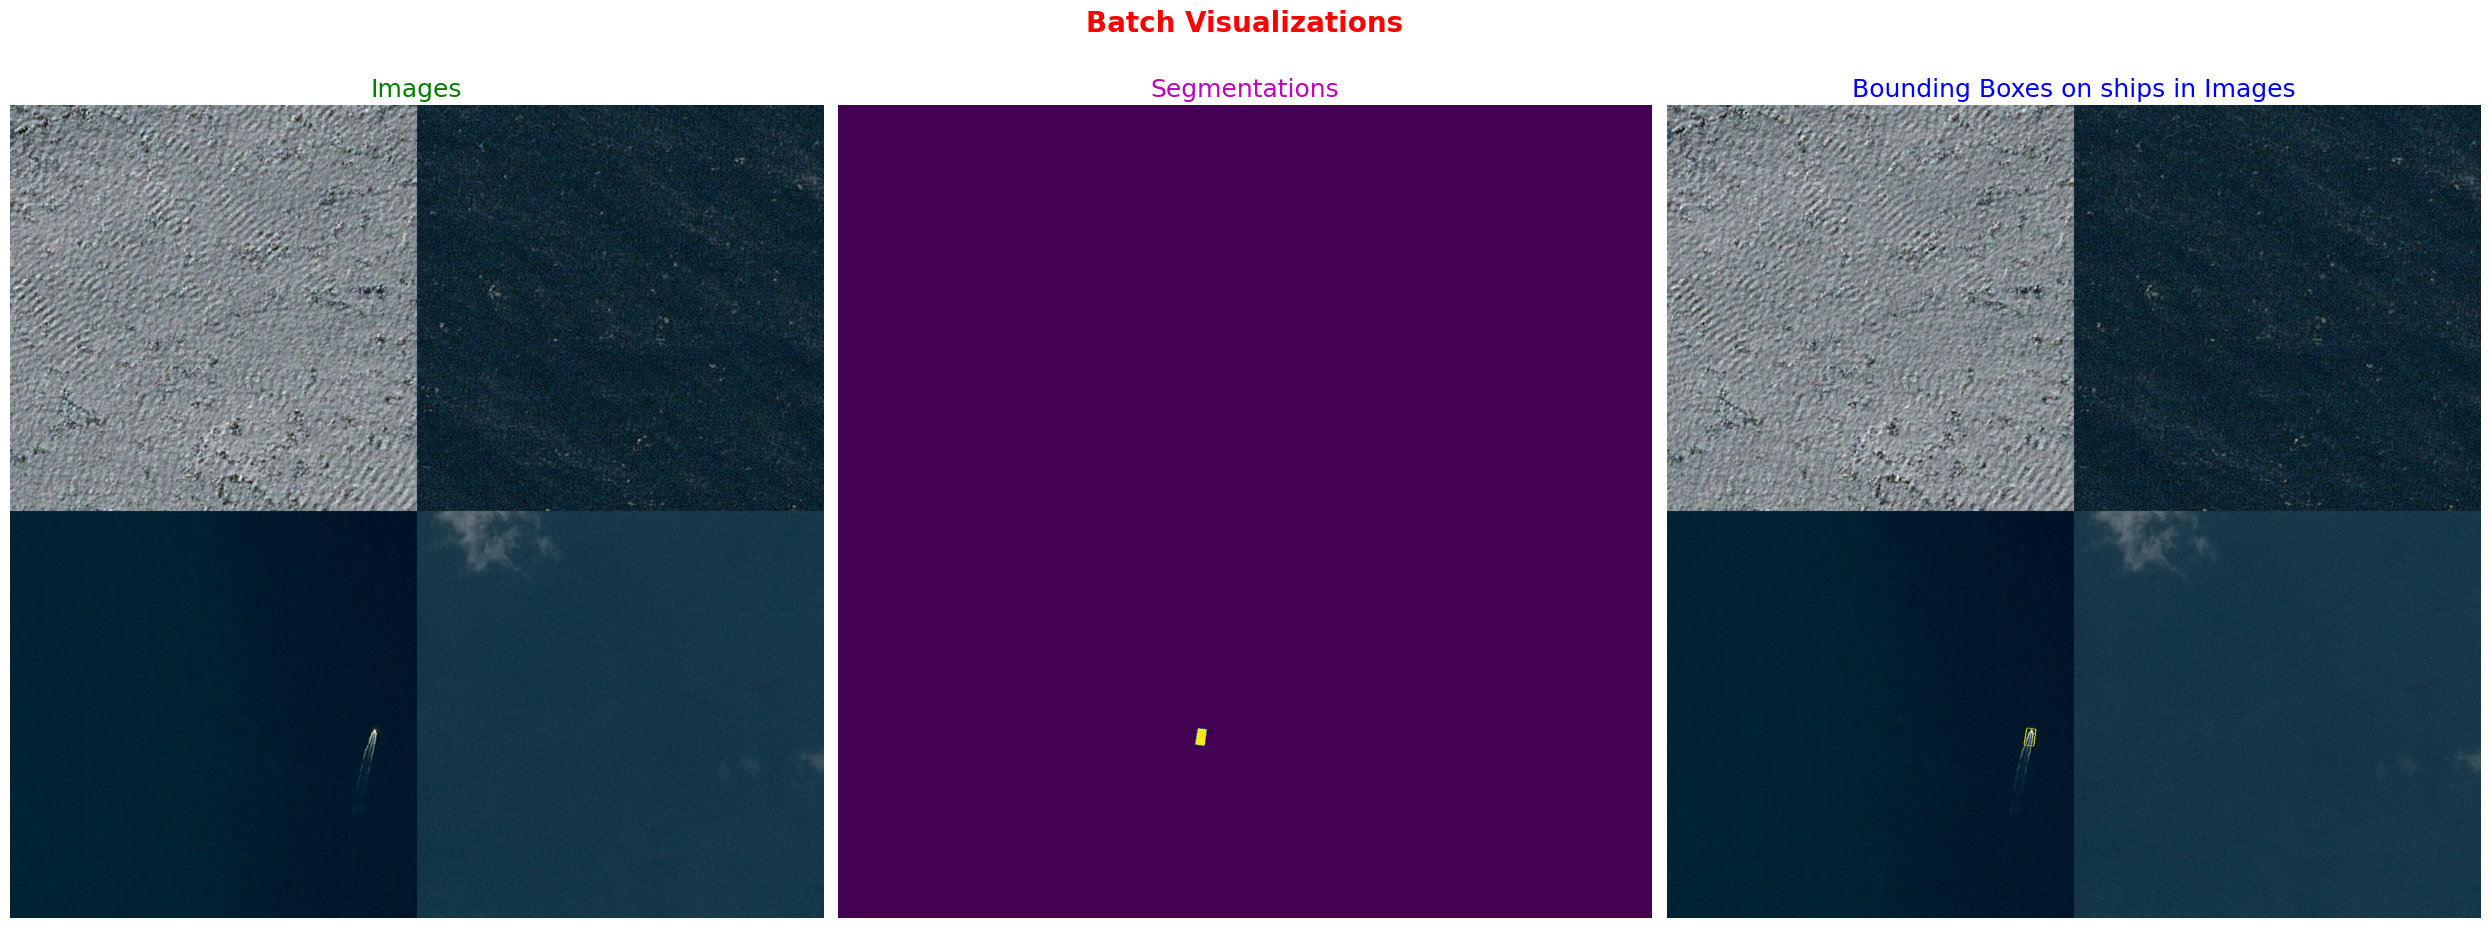

In [ ]:
# Visulaising train batch
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
batch_rgb = montage_rgb(train_x)                                                   # Create montage of img
batch_seg = montage(train_y[:, :, :, 0])                                           # Create montafe of msk
batch_overlap = mark_boundaries(batch_rgb, batch_seg.astype(int))                  # Create bounding box around ships in img
titles = ["Images", "Segmentations", "Bounding Boxes on ships in Images"]          # Titles for subplot
colors = ['g', 'm', 'b']                                                           # Colors to be used for title
display = [batch_rgb, batch_seg, batch_overlap]                                    # What to display in subplot
plt.figure(figsize=(25,10))                                                        # Generate figure
for i in range(3):                                                                 # For i = 0, 1, 2, 3
    plt.subplot(1, 3, i+1)                                                         # Create subplot
    plt.imshow(display[i])                                                         # Display
    plt.title(titles[i], fontsize = 18, color = colors[i])                         # Title
    plt.axis('off')                                                                # Turn off the axis
plt.suptitle("Batch Visualizations", fontsize = 20, color = 'r', weight = 'bold')  # Add suptitle
plt.tight_layout()                                                                 # Layout for subplot

In [ ]:
# Prepare validation data
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(f"valid_x ~\nShape: {valid_x.shape}\nMin value: {valid_x.min()}\nMax value: {valid_x.max()}")
print(f"\nvalid_y ~\nShape: {valid_y.shape}\nMin value: {valid_y.min()}\nMax value: {valid_y.max()}")

valid_x ~
Shape: (400, 768, 768, 3)
Min value: 0.0
Max value: 1.0

valid_y ~
Shape: (400, 768, 768, 1)
Min value: 0
Max value: 1


In [ ]:
# Augmenting Data using ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

# Preparing image data generator arguments
dg_args = dict(rotation_range = 15,            # Degree range for random rotations
               horizontal_flip = True,         # Randomly flips the inputs horizontally
               vertical_flip = True,           # Randomly flips the inputs vertically
               data_format = 'channels_last')  # channels_last refer to (batch, height, width, channels)

Generate batches of tensor image data with real-time data augmentation.

In [ ]:
image_gen = ImageDataGenerator(**dg_args)
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    '''
    Takes in -
    in_gen - train data generator, seed value
    '''
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))  # Randomly assign seed value if not provided
    for in_x, in_y in in_gen:                                                    # For imgs and msks in train data generator
        seed = 12                                                                # Seed value for imgs and msks must be same else augmentation won't be same

        # Create augmented imgs
        g_x = image_gen.flow(255*in_x,                                           # Inverse scaling on imgs for augmentation
                             batch_size = in_x.shape[0],                         # batch_size = 3
                             seed = seed,                                        # Seed
                             shuffle=True)                                       # Shuffle the data

        # Create augmented masks
        g_y = label_gen.flow(in_y,
                             batch_size = in_x.shape[0],
                             seed = seed,
                             shuffle=True)

        '''Yeilds - augmented scaled imgs and msks array'''
        yield next(g_x)/255.0, next(g_y)

In [ ]:
# Augment the train data
cur_gen = create_aug_gen(train_gen, seed = 42)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

x (4, 768, 768, 3) float32 0.0 0.95703274
y (4, 768, 768, 1) float32 0.0 0.0


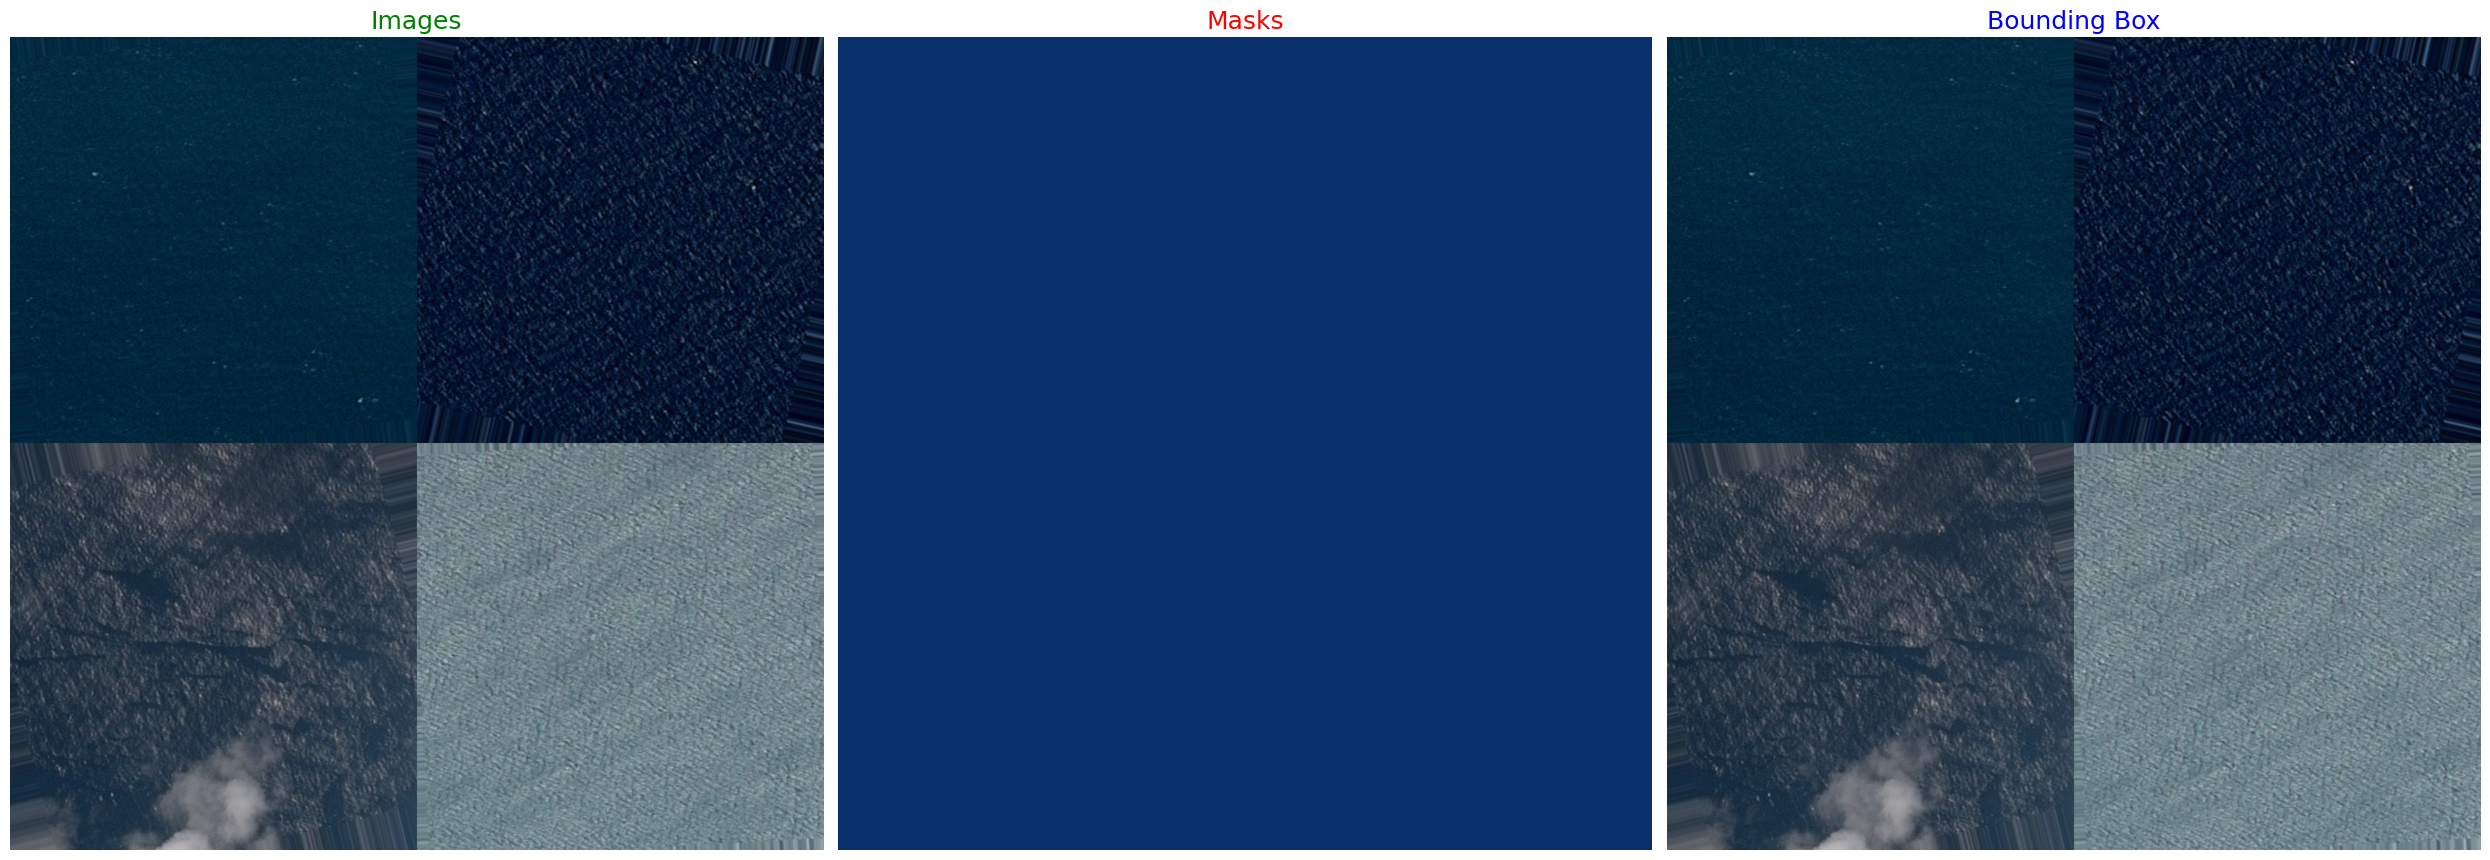

In [ ]:
# Final display before passing data into model
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (25, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('Images', fontsize = 18, color = 'g')
ax1.axis('off')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='Blues_r')
ax2.set_title('Masks', fontsize = 18, color = 'r')
ax2.axis('off')
ax3.imshow(mark_boundaries(montage_rgb(t_x), montage(t_y[:, :, :, 0].astype(int))))
ax3.set_title('Bounding Box', fontsize = 18, color = 'b')
ax3.axis('off')
plt.tight_layout()

In [ ]:
gc.collect() # Block all the garbage that has been generated

8444

**A brief introduction on U-NET architecture**

![image.png](attachment:9660d910-4d61-4331-9eb0-385c58c84472.png)

The name U-NET itself is due to the shape of its architecture.
- Each blue box corresponds to a multi-channel feature map.
- The number of channels are denoted on top of the box.
- The x-y size is provided at the lower left edge of the box.
- The arrows shows the respective operations as mentioned on the bottom right of the image.
- This architecture consists of three sections: The contraction, The bottleneck, and the expansion section.
- But the heart of this architecture lies in the expansion section.
- This action would ensure that the features that are learned while contracting the image will be used to reconstruct it.

![image.png](attachment:5f8ac227-ce4f-4a8e-95d9-062436bb85e4.png)

In [ ]:
# Build U-Net model
from keras import models, layers

# Conv2DTranspose upsampling
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
# Upsampling without Conv2DTranspose
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

# Upsampling method choice
if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple

# Building the layers of UNET
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img

# If NET_SCALING is defined then do the next step else continue ahead
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)

# To avoid overfitting and fastening the process of training
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)                       # Useful to mitigate overfitting
pp_in_layer = layers.BatchNormalization()(pp_in_layer)                                # Allows using higher learning rate without causing problems with gradients


## Downsample (C-->C-->MP)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

## Upsample (U --> Concat --> C --> C)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)

if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])

seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB_Input (InputLayer)         [(None, 768, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 768, 768, 3)  0          ['RGB_Input[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 768, 768, 3)  12         ['gaussian_noise[0][0]']         
 alization)                                                                                       
                                                                                              